# Model NAME

- small description of the model (data normalization, model type, techniques used, ...)

- features used (hcpi_m, anything else?)

- version (update of other model? what did you change?)

In [1]:
import pandas as pd
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

read the df and filter 2010 to 2023

In [2]:
hcpi = pd.read_parquet("data/hcpi_m.parquet").loc["2010-01":"2023-12"]

print(hcpi.shape)
hcpi.head(3)

(168, 185)


,ABW,AFG,AGO,ALB,ARE,ARG,ARM,ATG,AUT,AZE,...,VCT,VEN,VGB,VNM,WSM,XKX,YEM,ZAF,ZMB,ZWE
2010-01-01,90.518,73.652677,18.297409,82.400000,88.008742,NaN,97.670572,86.417242,89.04379,97.2,...,100.0,166.5,NaN,58.542273,90.343792,87.955386,110.846,75.30460,105.0,1.871011
2010-02-01,90.396,72.992480,18.459746,83.600000,87.859764,NaN,97.571898,86.617995,89.20885,98.3,...,100.1,169.1,NaN,59.689701,91.718191,88.191825,111.095,75.77624,105.5,1.887481
2010-03-01,90.623,72.924208,18.654168,83.691822,87.943564,NaN,98.220672,86.596486,90.19913,99.6,...,100.2,173.2,NaN,60.137374,92.084697,88.113012,111.469,76.40508,106.6,1.910539


In [3]:
# count columns with missing values
missing = hcpi.isna().sum()
print(f"We still have {hcpi.shape[1] - len(missing[missing > 0])} countries out of {hcpi.shape[1]}.")

We still have 163 countries out of 185.


# IDENTIFYING ANOMALIES BY COUNTRY

In [4]:
port_ts = pd.read_parquet("data/hcpi_m.parquet").loc[:, "PRT"]
print(f"No missing values? {port_ts.isna().sum() == 0}")

port_ts

No missing values? True


1970-01-01      1.702706
1970-02-01      1.680877
1970-03-01      1.716598
1970-04-01      1.706675
1970-05-01      1.687823
                 ...    
2024-11-01    122.043000
2024-12-01    122.173000
2025-01-01    121.622000
2025-02-01    121.489000
2025-03-01    123.217000
Name: PRT, Length: 663, dtype: float64

## prediction-based with scheduled online learning

In [5]:
class LSTMPredictor(nn.Module):
    def __init__(self, input_dim=1, hidden_dim=16, seq_len=12):
        super().__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, 1)
        self.seq_len = seq_len

    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]  # last time step
        out = self.linear(out)
        return out.squeeze()
    

def make_supervised(series, seq_len):
    X, y = [], []
    for i in range(len(series) - seq_len):
        X.append(series[i:i+seq_len])
        y.append(series[i+seq_len])
    return np.array(X), np.array(y)

def normalize(series, mean=None, std=None):
    series = np.log1p(series)
    if mean is None:
        mean = np.mean(series)
        std = np.std(series)
    return (series - mean) / std, mean, std

def denormalize(norm_series, mean, std):
    return np.expm1(norm_series * std + mean)

In [6]:
seq_len = 12
initial_months = 24  # 12 context + 12 train
retrain_every = 6    # retrain every 6 months

series = port_ts.values.astype(np.float32)
dates = port_ts.index.to_list()

train_series = series[:initial_months]
stream_series = series[initial_months:]
stream_dates = dates[initial_months:]

In [7]:
# initial train, using the initial_months and the normalized() series
train_norm, mean, std = normalize(train_series)
X_train, y_train = make_supervised(train_norm, seq_len)

X_train_tensor = torch.tensor(X_train[..., np.newaxis], dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

model = LSTMPredictor()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.MSELoss()

for epoch in range(100):
    optimizer.zero_grad()
    out = model(X_train_tensor)
    loss = criterion(out, y_train_tensor)
    loss.backward()
    optimizer.step()

# define the threshold for anomaly detection
model.eval()
with torch.no_grad():
    preds = model(X_train_tensor)
    residuals = torch.abs(preds - y_train_tensor).numpy()
    threshold = max(np.percentile(residuals, 95), 2.5)

In [8]:
anomaly_dates, anomaly_values = [], []

aaaaaa = []

future_train_data = train_series

month_counter = 0

# start streaming the new data
for t in range(seq_len, len(stream_series)):

    # get the last seq_len months of data
    window = stream_series[t-seq_len:t]
    x = normalize(window, mean, std)[0]
    x_tensor = torch.tensor(x[np.newaxis, :, np.newaxis], dtype=torch.float32)

    # predict the next value (the current month)
    with torch.no_grad():
        pred = model(x_tensor).item()
        pred_denorm = denormalize(pred, mean, std)
        aaaaaa.append(pred_denorm)

    # get the true value
    date_t = stream_dates[t]
    true_val = stream_series[t]
    true_val_norm = normalize(true_val, mean, std)[0]

    # check for anomalies
    err = abs(pred - true_val_norm)
    if err > threshold:
        print(f"{date_t.strftime('%Y-%m')}  anomaly (error={err:.4f})")
        anomaly_dates.append(date_t)
        anomaly_values.append(true_val)

    future_train_data = np.append(future_train_data, true_val)
    month_counter += 1
    # retrain the model if should
    if month_counter % retrain_every == 0:
        # get the last seq_len months of data
        train_data = future_train_data[-(int(seq_len*1.5)):]
        train_data_norm, mean, std = normalize(train_data)

        # prepare the data for training
        X_train, y_train = make_supervised(train_data_norm, seq_len)
        X_train_tensor = torch.tensor(X_train[..., np.newaxis], dtype=torch.float32)
        y_train_tensor = torch.tensor(y_train, dtype=torch.float32)

        # retrain the model
        model = LSTMPredictor()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        for epoch in range(50):
            optimizer.zero_grad()
            out = model(X_train_tensor)
            loss = criterion(out, y_train_tensor)
            loss.backward()
            optimizer.step()

        # define the new threshold
        model.eval()
        with torch.no_grad():
            preds = model(X_train_tensor)
            residuals = torch.abs(preds - y_train_tensor).numpy()
            threshold = max(np.percentile(residuals, 95), 2.5)

1976-10  anomaly (error=2.6302)
1976-11  anomaly (error=2.8025)
1976-12  anomaly (error=3.4080)
1981-04  anomaly (error=2.5870)
1981-05  anomaly (error=2.6518)
1981-06  anomaly (error=2.7573)
1981-12  anomaly (error=2.5729)
1983-10  anomaly (error=2.5355)
1983-11  anomaly (error=2.8018)
1983-12  anomaly (error=3.2719)
1988-11  anomaly (error=2.5899)
1988-12  anomaly (error=2.8666)
1992-06  anomaly (error=2.5138)
2000-05  anomaly (error=2.7771)
2000-06  anomaly (error=3.3028)
2000-11  anomaly (error=2.7431)
2000-12  anomaly (error=3.0773)
2006-03  anomaly (error=2.6179)
2006-04  anomaly (error=3.0433)
2006-05  anomaly (error=3.3965)
2006-06  anomaly (error=3.3507)
2008-06  anomaly (error=2.7551)
2010-10  anomaly (error=2.6667)
2010-11  anomaly (error=2.9337)
2010-12  anomaly (error=3.3922)
2011-03  anomaly (error=3.2989)
2011-04  anomaly (error=3.6523)
2011-05  anomaly (error=3.5683)
2011-06  anomaly (error=3.3339)
2014-02  anomaly (error=2.7197)
2015-01  anomaly (error=2.6487)
2015-02 

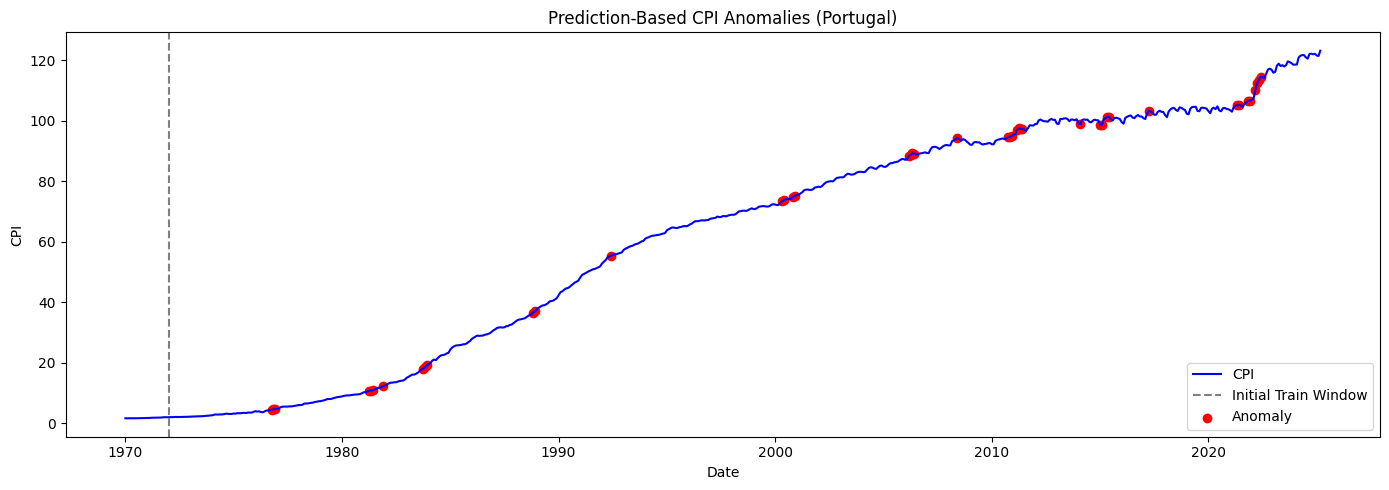

In [9]:
plt.figure(figsize=(14, 5))
plt.plot(dates, series, label="CPI", color='blue')
plt.axvline(x=dates[initial_months], color='gray', linestyle='--', label='Initial Train Window')
#for d in retrain_dates:
#    plt.axvline(x=d, color='green', linestyle='--', alpha=0.2)
plt.scatter(anomaly_dates, anomaly_values, color='red', label='Anomaly')
#plt.plot(all_pred_dates, all_preds, color='orange', label='Prediction')
plt.title("Prediction-Based CPI Anomalies (Portugal)")
plt.xlabel("Date")
plt.ylabel("CPI")
plt.legend()
plt.tight_layout()
plt.show()